In [2]:
import numpy as np
import pandas as pd

from data import gen_adult_probs
from eval import get_eval_single

from src.bin_postprocess import f_postprocess_vectorized_adjustments
from src.exact_solver import get_fpr, get_tpr

from fairlearn.metrics import selection_rate, true_positive_rate, false_positive_rate

from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics import ClassificationMetric, utils
from aif360.datasets import BinaryLabelDataset

In [4]:
class ProbsCalibratedEqOddsPostprocessing(CalibratedEqOddsPostprocessing):
    
    def test_print(self):
        print(self.cost_constraint)
    
    def predict_proba(self, dataset):
        if self.seed is not None:
            np.random.seed(self.seed)

        cond_vec_priv = utils.compute_boolean_conditioning_vector(
            dataset.protected_attributes,
            dataset.protected_attribute_names,
            self.privileged_groups)
        cond_vec_unpriv = utils.compute_boolean_conditioning_vector(
            dataset.protected_attributes,
            dataset.protected_attribute_names,
            self.unprivileged_groups)

        unpriv_indices = (np.random.random(sum(cond_vec_unpriv))
                       <= self.unpriv_mix_rate)
        unpriv_new_pred = dataset.scores[cond_vec_unpriv].copy()
        unpriv_new_pred[unpriv_indices] = self.base_rate_unpriv

        priv_indices = (np.random.random(sum(cond_vec_priv))
                     <= self.priv_mix_rate)
        priv_new_pred = dataset.scores[cond_vec_priv].copy()
        priv_new_pred[priv_indices] = self.base_rate_priv

        dataset_new = dataset.copy(deepcopy=True)

        dataset_new.scores_new = np.zeros_like(dataset.scores, dtype=np.float64)
        dataset_new.scores_new[cond_vec_priv] = priv_new_pred
        dataset_new.scores_new[cond_vec_unpriv] = unpriv_new_pred

        # # Create labels from scores using a default threshold
        # dataset_new.labels = np.where(dataset_new.scores >= threshold,
        #                               dataset_new.favorable_label,
        #                               dataset_new.unfavorable_label)
        return dataset_new

In [5]:
privileged_groups = [{'group': 1}]
unprivileged_groups = [{'group': 0}]

In [104]:
allscores = gen_adult_probs()
ds_orig = BinaryLabelDataset(df=allscores, label_names=['label'], protected_attribute_names=['group'])
ds_pred = ds_orig.copy()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [99]:
ds_pred.scores = allscores['score'].ravel().reshape(-1, 1)
ds_pred.labels = (allscores['score'] > 0.5).astype(int).values.reshape(-1, 1)
# ds_pred.protected_attributes = ds_pred.protected_attributes.reshape(-1)

In [43]:
for constraint in ['fpr', 'fnr', 'weighted']:
    prb = ProbsCalibratedEqOddsPostprocessing(unprivileged_groups, privileged_groups, cost_constraint=constraint)
    prb.fit(ds_orig, ds_pred)
    ret = prb.predict_proba(ds)
    allscores[constraint] = ret.scores_new

In [44]:
adjust = f_postprocess_vectorized_adjustments(allscores.score.values, allscores.score.values,allscores.group.values, allscores.group.values)
allscores['adjust'] = adjust

In [45]:
allscores['ours_fullrep'] = allscores.score.values + adjust
tprlambda = get_tpr(allscores, 'score', 'group', 'adjust')
fprlambda = get_fpr(allscores, 'score', 'group', 'adjust')
allscores['ours_tpr'] = allscores.score.values + tprlambda*adjust
allscores['ours_fpr'] = allscores.score.values + fprlambda*adjust
allscores['ours_sketcheo'] = allscores.score.values + 0.5*(tprlambda+fprlambda)*adjust

In [46]:
def get_05_results(probs, grp, y_te):
    preds05 = probs > 0.5
    prd05 = np.abs(np.mean(preds05[grp == 0]) - np.mean(preds05[grp == 1]))
    acc05 = np.mean(preds05 == y_te)
    tprd05 = np.abs(true_positive_rate(y_te[grp==0],preds05[grp==0]) - true_positive_rate(y_te[grp==1],preds05[grp==1]))
    fprd05 = np.abs(false_positive_rate(y_te[grp==0],preds05[grp==0]) - false_positive_rate(y_te[grp==1],preds05[grp==1]))

    return {'prd_05': prd05, 'tprd_05': tprd05, 'fprd_05': fprd05, 'acc_05': acc05}


In [47]:
all_results = pd.DataFrame(columns=['method', 'avg_prd', 'avg_tprd', 'avg_eod', 'avg_acc'])

method_to_name_map = {
    'score': 'uncorrected',
    'fpr': 'pleiss_fpr',
    'fnr': 'pleiss_tpr',
    'weighted': 'pleiss_weighted'
}

for method in ['score', 'fnr', 'fpr', 'weighted', 'ours_fullrep', 'ours_tpr', 'ours_fpr', 'ours_sketcheo']:

    results = get_eval_single(allscores.label.values, allscores[method].values, allscores.group.values)
    res05 = get_05_results(allscores[method].values, allscores.group.values,allscores.label.values)

    all_results = all_results.append({
        'method': method_to_name_map[method] if method in method_to_name_map else method,
        'avg_prd': np.mean(np.abs(results['positivity_rate_differences'])),
        'avg_tprd': np.mean(np.abs(results['tpr_differences'])),
        'avg_eod': np.mean(results['eqodds_differences']),
        'avg_acc': np.mean(results['acc_overall']),
        'prd_05': res05['prd_05'],
        'tprd_05': res05['tprd_05'],
        'eod_05': res05['tprd_05'] + res05['fprd_05'], 
        'acc_05': res05['acc_05']
    }, ignore_index=True)

In [50]:
res_tmp = get_eval_single(allscores.label.values, allscores['fnr'].values, allscores.group.values)    

In [51]:
res_tmp.head()

,thresholds,positivity_rate_differences,tpr_differences,fpr_differences,eqodds_differences,tpr_A,tpr_B,selection_A,selection_B,fpr_A,fpr_B,acc_A,acc_B,acc_overall
0,0.00,0.156798,0.031336,0.128391,0.159727,0.981683,0.950346,0.843700,0.686903,0.783559,0.655168,0.448735,0.409932,0.435936
1,0.01,0.175357,0.049992,0.139948,0.189940,0.972625,0.922633,0.812477,0.637120,0.742674,0.602726,0.474459,0.453755,0.467630
2,0.02,0.182735,0.051178,0.144636,0.195814,0.964573,0.913395,0.793535,0.610801,0.718986,0.574350,0.488513,0.478088,0.485074
3,0.03,0.186837,0.054028,0.146743,0.200771,0.959340,0.905312,0.781498,0.594662,0.703983,0.557240,0.497373,0.492489,0.495762
4,0.04,0.193670,0.055119,0.152312,0.207431,0.953502,0.898383,0.769461,0.575791,0.689244,0.536931,0.505866,0.509870,0.507186


In [59]:
res_orig = get_eval_single(allscores.label.values, allscores['score'].values, allscores.group.values)    

In [60]:
res_ours = get_eval_single(allscores.label.values, allscores['ours_tpr'].values, allscores.group.values)

In [52]:
import matplotlib.pyplot as plt

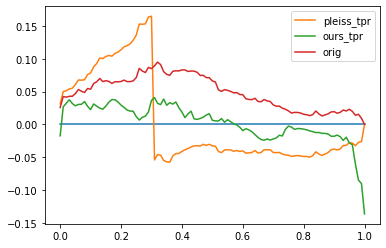

In [116]:
plt.plot([0, 1], [0, 0])
plt.plot(res_tmp['thresholds'], res_tmp['tpr_differences'], label='pleiss_tpr')
plt.plot(res_tmp['thresholds'], res_ours['tpr_differences'], label='ours_tpr')
plt.plot(res_tmp['thresholds'], res_orig['tpr_differences'], label='orig')

plt.legend()

In [48]:
all_results

,method,avg_prd,avg_tprd,avg_eod,avg_acc,acc_05,eod_05,prd_05,tprd_05
0,uncorrected,0.096611,0.048576,0.070793,0.769545,0.819745,0.080760,0.098445,0.066211
1,pleiss_tpr,0.104847,0.058683,0.115916,0.745334,0.806683,0.033452,0.057812,0.032823
2,pleiss_fpr,0.096611,0.048576,0.070793,0.769545,0.819745,0.080760,0.098445,0.066211
3,pleiss_weighted,0.229420,0.430870,0.572486,0.765033,0.822857,0.548056,0.195527,0.473833
4,ours_fullrep,0.005846,0.091005,0.154092,0.754395,0.804226,0.179278,0.000542,0.111132
5,ours_tpr,0.067520,0.021869,0.034724,0.764304,0.813603,0.019602,0.064052,0.006165
6,ours_fpr,0.079006,0.027099,0.037150,0.766139,0.816019,0.038089,0.080576,0.037523
7,ours_sketcheo,0.073238,0.023856,0.034736,0.765146,0.814627,0.030713,0.070100,0.021388


In [3]:
scores = pd.read_csv('fair_baselines/adult_new_results/pleiss__scores.csv')

In [5]:
scores.trial.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
np.mean(scores.score == scores.scores_tpr)

0.8944405559444055